# DBSCAN Clustering w/ SUM encoding

The purpose of this notebook is to obtain comparable results to the ones returned by the forward feature selection, to check if they are any good, wihtout considering channel behavioral data.

## Libraries and Configurations

Import configuration files

In [93]:
from configparser import ConfigParser

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

Import **data libraries**

In [94]:
import pandas as pd

Import **other libraries**

In [95]:
from rich.progress import Progress
from rich import traceback

traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x75e89ac63c10>>

Custom helper scripts

In [96]:
%cd ..
from scripts import plotHelper, encodingHelper
%cd data_exploration_cleaning

/home/bacci/COMPACT/notebooks
/home/bacci/COMPACT/notebooks/data_exploration_cleaning


## Import Data

In [97]:
# Combined dataframe
combined_df_csv = (
    config["DEFAULT"]["interim_path"] + "encoded_SUM_balanced_df_length.csv"
)

In [98]:
df = pd.read_csv(combined_df_csv, index_col=0)

In [99]:
df

,Timestamp,MAC Address,Channel,DS Channel,HT Capabilities SUM,Extended Capabilities SUM,Vendor Specific Tags SUM,Supported Rates SUM,Extended Supported Rates SUM,Length,Label,Length NO SSID
0,2023-05-20 13:52:01.864465952,d2:6b:aa:b5:fb:ed,1,1.0,2709,830,-1,479,915,135,iPhone12Pro_C,135
1,2023-05-20 13:52:01.884716034,d2:6b:aa:b5:fb:ed,1,1.0,2709,830,-1,479,915,135,iPhone12Pro_C,135
2,2023-05-20 13:52:01.910542011,d2:6b:aa:b5:fb:ed,6,6.0,2709,830,-1,479,915,135,iPhone12Pro_C,135
3,2023-05-20 13:52:01.930788994,d2:6b:aa:b5:fb:ed,6,6.0,2709,830,-1,479,915,135,iPhone12Pro_C,135
4,2023-05-20 13:52:01.968745947,d2:6b:aa:b5:fb:ed,11,11.0,2709,830,-1,479,915,135,iPhone12Pro_C,135
...,...,...,...,...,...,...,...,...,...,...,...,...
36055,2021-07-07 12:02:57.579541922,da:a1:19:00:17:f9,6,1.0,2663,1032,747,447,915,182,XiaomiRedmiNote7_S,182
36056,2021-07-07 11:32:04.533828019,da:a1:19:1a:cc:8f,6,8.0,2663,1032,747,447,915,198,XiaomiRedmiNote7_S,182
36057,2021-07-07 11:46:50.089955091,da:a1:19:41:c9:b1,11,5.0,2663,1032,747,447,915,143,XiaomiRedmiNote7_S,143
36058,2021-07-07 12:16:31.309731960,da:a1:19:c7:24:b1,1,3.0,2663,1032,747,447,915,182,XiaomiRedmiNote7_S,182


Removing features different from the one used in Pintor work

In [100]:
df = df[
    [
        "MAC Address",
        "HT Capabilities SUM",
        "Extended Capabilities SUM",
        "Vendor Specific Tags SUM",
        "Label",
    ]
]

## Burst View

In [101]:
burst_df = df.groupby("MAC Address").agg(pd.Series.mode).reset_index()

In [102]:
burst_df

,MAC Address,HT Capabilities SUM,Extended Capabilities SUM,Vendor Specific Tags SUM,Label
0,00:0f:00:6a:68:8b,2719,815,18612,SamsungJ6_K
1,00:be:3b:a2:a8:56,2767,655,2551,HuaweiP20_G
2,02:00:00:00:00:00,2667,837,743,SamsungM31_A
3,02:00:00:00:3e:b2,2713,544,-1,iPhone11_C
4,02:00:3a:5e:a1:f4,2713,544,-1,iPhone11_B
...,...,...,...,...,...
4410,fe:f9:ac:47:0d:b7,2713,544,-1,iPhone12_W
4411,fe:f9:fc:fb:83:9e,2619,748,1174,iPhone6_N
4412,fe:fc:07:34:10:69,2713,544,-1,iPhone11_C
4413,fe:fc:aa:d1:89:d1,2713,544,-1,iPhone12_W


Dropping devices that did not randomize MAC Address between different bursts

In [103]:
label_count = burst_df["Label"].value_counts()
devices_to_drop = label_count[label_count == 1].index.tolist()
burst_df = burst_df[~burst_df["Label"].isin(devices_to_drop)]

## Normalize Data

In [104]:
burst_df.fillna("-1", inplace=True)

/tmp/ipykernel_25905/1153771547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burst_df.fillna("-1", inplace=True)


In [105]:
numeric_columns = [
    col for col in burst_df.columns if col not in ["MAC Address", "Label"]
]

# Convert selected columns to numeric type
burst_df[numeric_columns] = burst_df[numeric_columns].apply(
    pd.to_numeric, errors="coerce"
)

/tmp/ipykernel_25905/1427331824.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burst_df[numeric_columns] = burst_df[numeric_columns].apply(


In [106]:
from sklearn.preprocessing import MinMaxScaler

In [107]:
# Normalize each column using Min-Max scaling
scaler = MinMaxScaler()
burst_df[numeric_columns] = scaler.fit_transform(burst_df[numeric_columns])

/tmp/ipykernel_25905/3984393403.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burst_df[numeric_columns] = scaler.fit_transform(burst_df[numeric_columns])


## Split Columns

In [108]:
X = burst_df.drop(columns=["MAC Address", "Label"])
y = burst_df["Label"]

In [109]:
X.fillna("-1", inplace=True)

/tmp/ipykernel_25905/2071383555.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.fillna("-1", inplace=True)


## Clustering

In [110]:
from sklearn.cluster import DBSCAN

In [111]:
clusterer = DBSCAN(eps=0.00001, min_samples=10).fit(X)

In [112]:
burst_df["Cluster"] = clusterer.labels_

/tmp/ipykernel_25905/4186161744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burst_df["Cluster"] = clusterer.labels_


In [113]:
print("Number of clusters found:", burst_df["Cluster"].nunique())
print("Actual number of devices:", burst_df["Label"].nunique())

Number of clusters found: 30
Actual number of devices: 27


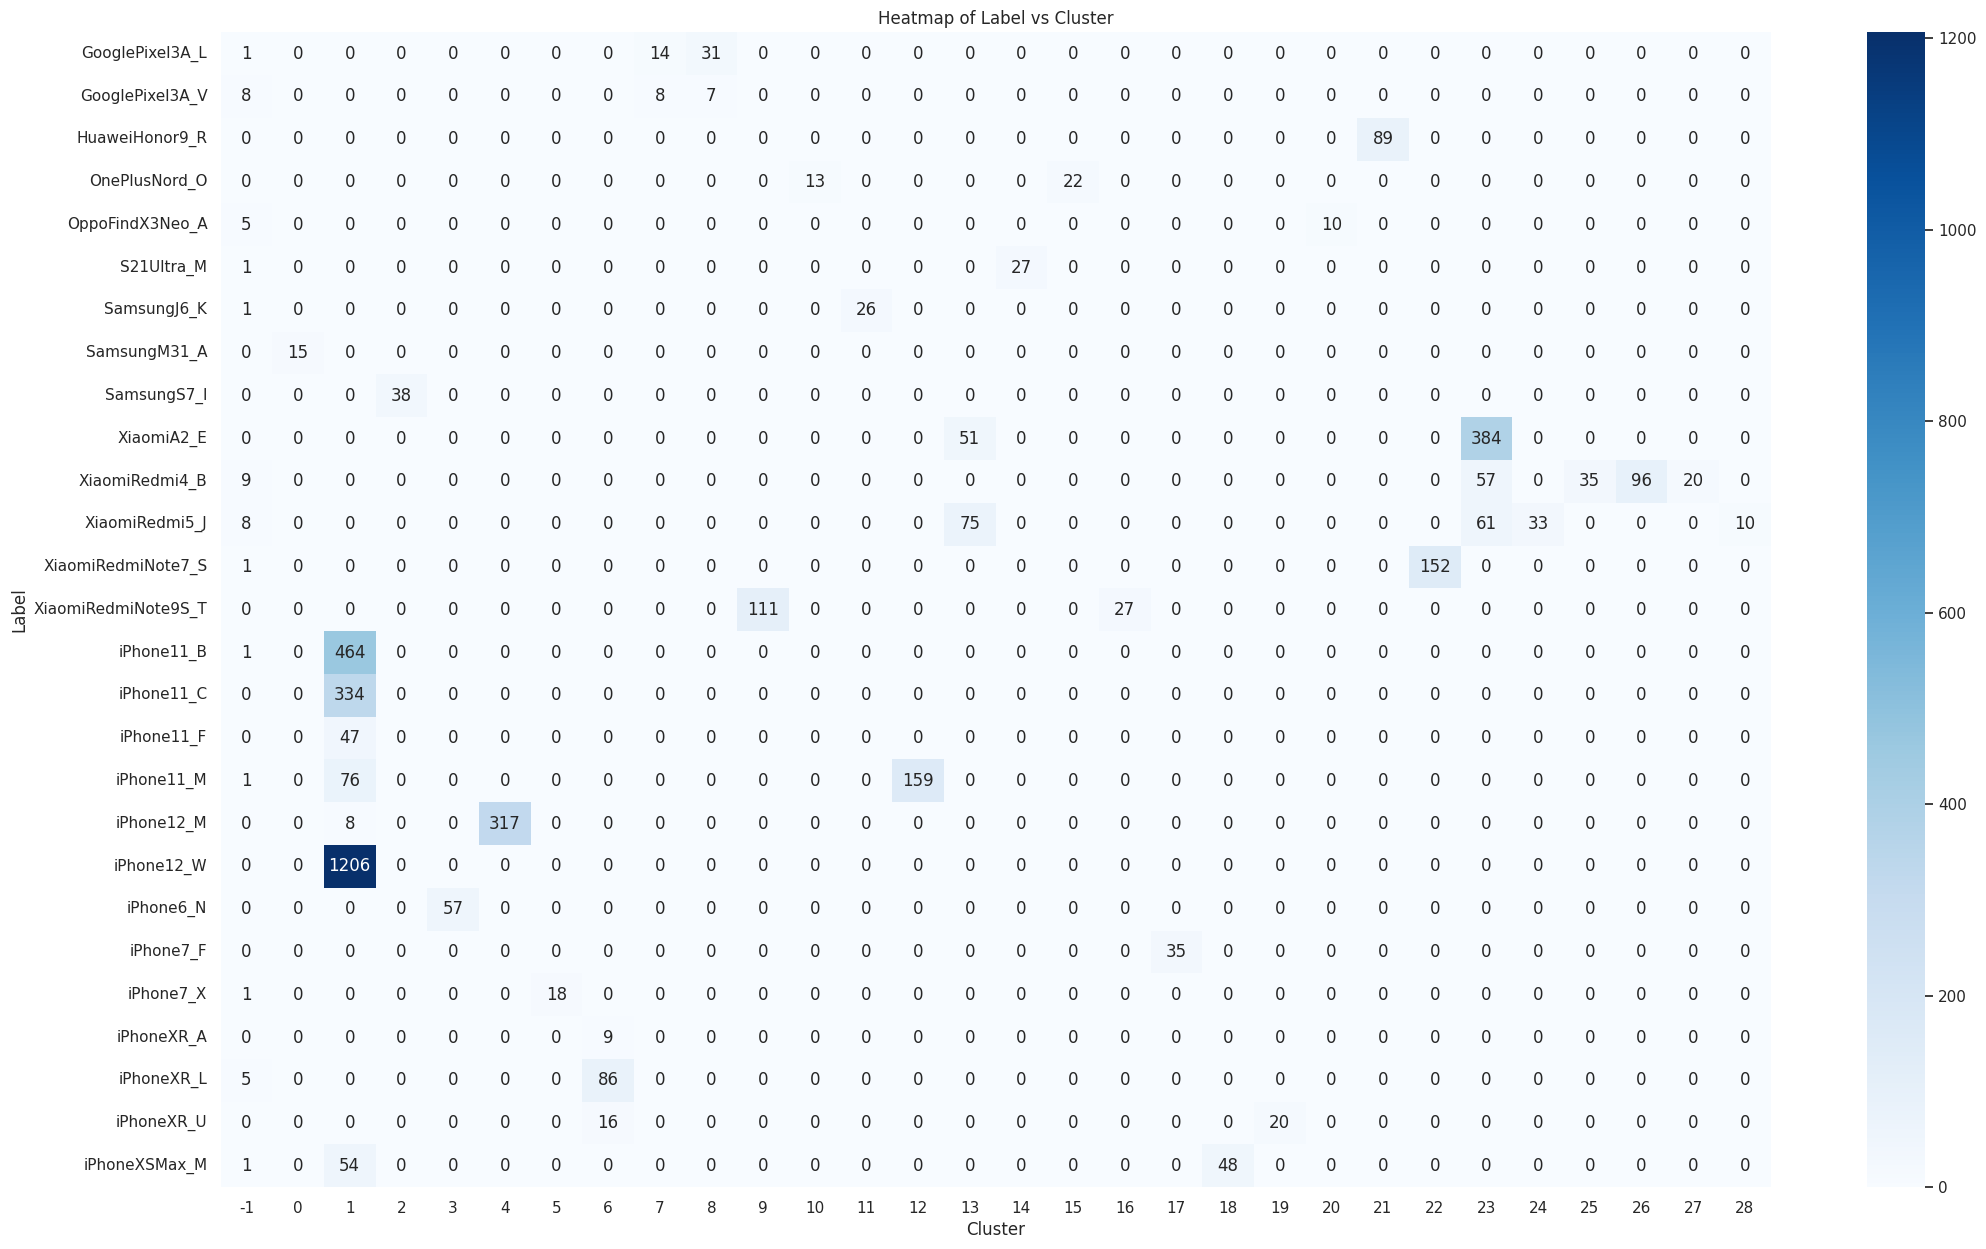

In [114]:
plotHelper.plot_heatmap(burst_df, "Label", "Cluster")

## Clustering Metrics

In [115]:
from sklearn.metrics import homogeneity_completeness_v_measure
from math import sqrt

In [116]:
h, c, v = homogeneity_completeness_v_measure(burst_df["Label"], burst_df["Cluster"])
print("Homogeneity: \t", h)
print("Completeness: \t", c)
print("V-measure: \t", v)

Homogeneity: 	 0.7036458803842667
Completeness: 	 0.8704833274377408
V-measure: 	 0.7782232922826421


In [117]:
true_labels = len(set(y))
detected_clusters = burst_df["Cluster"].nunique()
rmse = sqrt((true_labels - detected_clusters) ** 2)
print("RMSE:", rmse)

RMSE: 3.0
